# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import f1_score,recall_score,precision_score

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn_pandas import DataFrameMapper
from joblib import dump, load


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [23]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]

100%|██████████| 87773/87773 [00:27<00:00, 3176.08it/s]


'taste great using air popper not great little seeds fall popping'

In [24]:
final['numbers_of_words']  = word_counter
word_counter[1822]

11

### [3.2] Preprocessing Review Summary

In [25]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 87773/87773 [00:17<00:00, 5126.58it/s]


'pop corn'

In [26]:
avg_w2v_trained_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_100000'
avg_w2v_test_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_100000'

w2v_tf_idf_trained_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_100000'
w2v_tf_idf_test_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_100000'

In [27]:
# Common Methods

alpha_values = (1e-4, 1e-3,1e-2,0.05,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1e0,3,5,7,9,1e1,1e2,1e3)
gamma_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]

def finding_best_alpha(X_tr,y_tr,which_method,whichAlgo, penalty):

    if whichAlgo == 'SGDClassifier' :
        # instantiate a SGDClassifier
        if penalty == 'l1':
            clf = SGDClassifier(loss='hinge', class_weight='balanced',n_jobs=-1, penalty='l1', random_state=1)
        else:
            clf = SGDClassifier(loss='hinge', class_weight='balanced',n_jobs=-1, penalty='l2', random_state=1)
        param_grid=dict(alpha=alpha_values)
    else:
        # instantiate a SVC
        clf = SVC(kernel='rbf', class_weight='balanced')
        param_grid=dict(gamma=gamma_values, C=gamma_values)
        
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=10)
    
    if which_method == 'gridsearch':
    
        # instantiate the grid for training data
        trained = GridSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10 )
    else:
        # instantiate the grid for training data
        trained = RandomizedSearchCV(clf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10, n_iter = 15)
        
    # fit with traing data
    trained.fit(X_tr, y_tr)
    
    return trained


# plot a graph which show difference between validation error and training error
def plotAccuracyGraph(training_grid):
    alpha_range = [i for i in alpha_values]
    accuracy = [i for i in training_grid.cv_results_['mean_train_score']]
    accuracy_test = [i for i in training_grid.cv_results_['mean_test_score']]
    plt.semilogx(alpha_range, accuracy,'r',label='train_accuracy')
    plt.semilogx(alpha_range, accuracy_test,'b',label='validation_accuracy')
    plt.title('Accuracy plot')
    plt.xlabel('Alpha') 
    plt.ylabel('Accuracy')
    plt.grid('on')
    plt.legend()
    plt.show()

# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# plot AUC curve
def plotAUC_ROC(nb_optimal,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = nb_optimal.predict_proba(X_test)
    train_probs = nb_optimal.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def show_most_informative_features(feature_names, clf, n=10):
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top_1 = coefs_with_fns[:n]
    top_2 = coefs_with_fns[:-(n + 1):-1]
    print(color.BOLD+"Important words in negative reviews\n"+color.END)
    for coeffs,features in top_1:
        print(coeffs,features)
    print("-----------------------------------------\n")
    print(color.BOLD+"Important words in positive reviews\n"+color.END)

    for coeffs,features in top_2:
        print(coeffs,features)
        

### Splitting data

__We have considered 100 k points__

In [28]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
##BoW

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn

# train data
X_train_bow = count_vect.fit_transform(X_train)

# test data
x_test_bow = count_vect.transform(x_test)


print('X_train_bow',X_train_bow.shape)
print('==='*10)
print('x_test_bow',x_test_bow.shape)

X_train_bow (61441, 36487)
x_test_bow (26332, 36487)


### Hyper parameter tunig using GridSearch

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

=======Training========
0.9369642557075345
{'alpha': 0.001}
SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


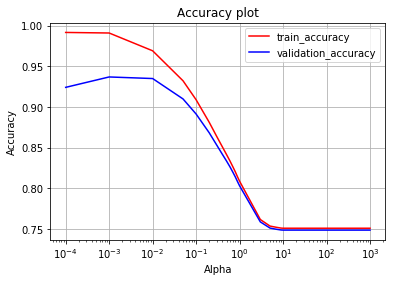

In [30]:
bow_train =finding_best_alpha (X_train_bow,y_train, 'gridsearch','SGDClassifier','l2')

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

plotAccuracyGraph(bow_train)

## Linear SVM     L1 Regularization 


Optimal best alpha is : 0.001

Confusion Matrix for Train data


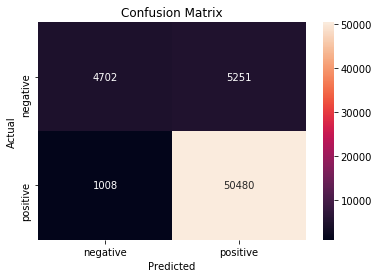


Confusion Matrix for Test data


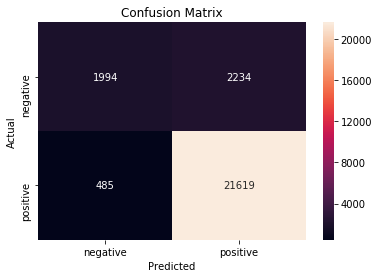

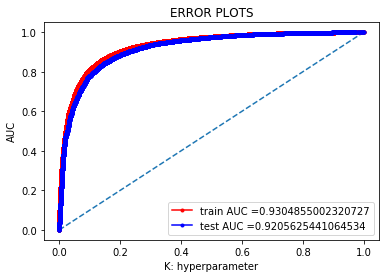


AUC (Train): 0.9304855002320727

AUC (Test): 0.9205625441064534

F1 SCORE (Train) : 0.9416241524356691

F1 SCORE (Test) : 0.9408359988685076

RECALL (Train): 0.9804226227470478

RECALL (Test): 0.9780582699963808

PRECISION  (Train) : 0.905779548186826

PRECISION  (Test) : 0.9063430176497715


In [31]:
optimal_alpha = bow_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L1 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L1.fit(X_train_bow,y_train)

# predict the response
test_pred = model_calib_L1.predict(x_test_bow)
train_pred = model_calib_L1.predict(X_train_bow)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L1,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## Linear SVM L2 Regularization


Optimal best alpha is : 0.001

Confusion Matrix for Train data


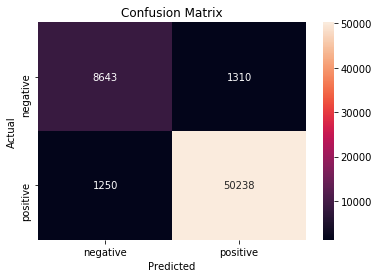


Confusion Matrix for Test data


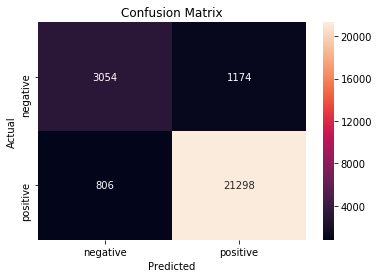

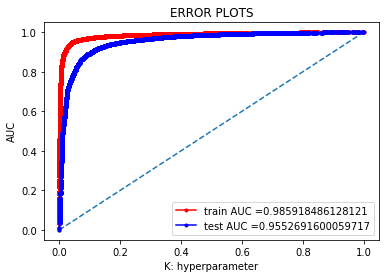


AUC (Train): 0.985918486128121

AUC (Test): 0.9552691600059717

F1 SCORE (Train) : 0.9751543149967

F1 SCORE (Test) : 0.9555814788226847

RECALL (Train): 0.9757224984462399

RECALL (Test): 0.9635360115816142

PRECISION  (Train) : 0.9745867928920617

PRECISION  (Test) : 0.9477572089711641


In [32]:
optimal_alpha = bow_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L2 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L2.fit(X_train_bow,y_train)

# predict the response
test_pred = model_calib_L2.predict(x_test_bow)
train_pred = model_calib_L2.predict(X_train_bow)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L2,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

In [33]:
optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(X_train_bow, y_train)

show_most_informative_features(count_vect.get_feature_names(), optimal_model)

Important words in negative reviews

-0.9265402882161373 not worth
-0.868904774466011 worst
-0.8606185565035934 disappointing
-0.8535091187893692 disappointed
-0.8086315489398109 not good
-0.785924409752272 not recommend
-0.7606546433752635 terrible
-0.7402320258694154 disappointment
-0.7194057068200203 awful
-0.6846237959575312 unfortunately
-----------------------------------------

Important words in positive reviews

0.9730794702159413 not disappointed
0.8535643108361439 delicious
0.8056453276669694 perfect
0.7351336849267136 wonderful
0.7216568792437671 excellent
0.7180157643558492 best
0.6905318802861331 amazing
0.6880332212639495 awesome
0.6852439751403764 loves
0.6798971724747347 yummy


### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(28000, 13) (12000, 13) (28000,) (12000,)

Confusion Matrix for Train data


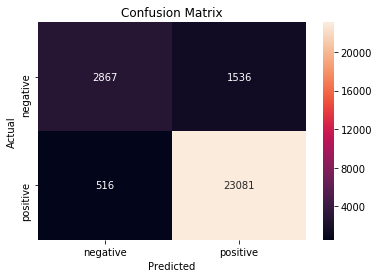


Confusion Matrix for Test data


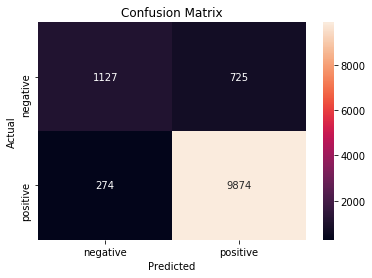

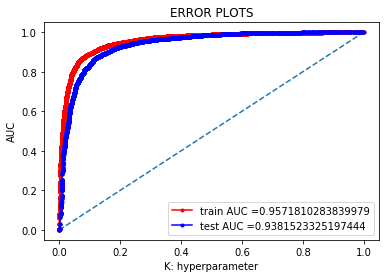


AUC (Train): 0.9571810283839979

AUC (Test): 0.9381523325197444

F1 SCORE (Train) : 0.9574397477910981

F1 SCORE (Test) : 0.9518484600183159

RECALL (Train): 0.9781328134932407

RECALL (Test): 0.9729996058336619

PRECISION  (Train) : 0.9376040947312833

PRECISION  (Test) : 0.9315973205019341


In [34]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:40000]
y = final['Score'][:40000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_alpha = bow_train.best_params_.get('alpha')

optimal_model =SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib.fit(train_features,y_train)

# predict the response
test_pred = model_calib.predict(test_features)
train_pred = model_calib.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.3] TF-IDF

In [35]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10) #in scikit-learn

# train data
X_train_tfidf = tf_idf_vect.fit_transform(X_train)

# test data
x_test_tfidf = tf_idf_vect.transform(x_test)

print('X_train_tfidf', X_train_tfidf.shape)
print('==='*10)
print('x_test_tfidf', x_test_tfidf.shape)

(61441,) (26332,) (61441,) (26332,)
X_train_tfidf (61441, 40217)
x_test_tfidf (26332, 40217)


### Hyper parameter tunig using GridSearch

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0822s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   12.2s finished


=======Training========
0.9406750568415551
{'alpha': 0.0001}
SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l1',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


/home/pranay/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


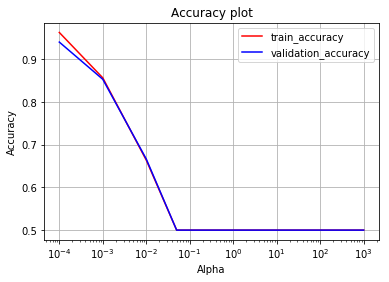

In [36]:
tfidf_train = finding_best_alpha (X_train_tfidf,y_train, 'gridsearch','SGDClassifier','l1')

# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

plotAccuracyGraph(tfidf_train)

# Linear SVM  L1 Regularization


Optimal best alpha is : 0.0001

Confusion Matrix for Train data


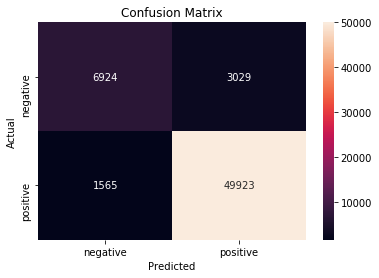


Confusion Matrix for Test data


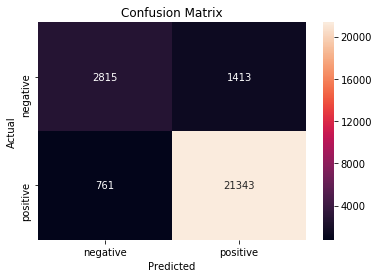

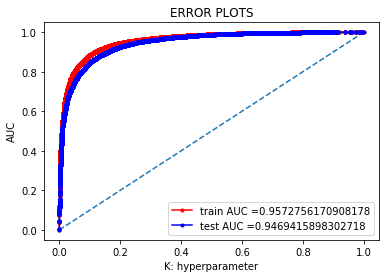


AUC (Train): 0.9572756170908178

AUC (Test): 0.9469415898302718

F1 SCORE (Train) : 0.9560130218307161

F1 SCORE (Test) : 0.9515381185911725

RECALL (Train): 0.9696045680546923

RECALL (Test): 0.9655718422005067

PRECISION  (Train) : 0.9427972503399304

PRECISION  (Test) : 0.9379064862014413


In [37]:
optimal_alpha = tfidf_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L1 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L1.fit(X_train_tfidf,y_train)

# predict the response
test_pred = model_calib_L1.predict(x_test_tfidf)
train_pred = model_calib_L1.predict(X_train_tfidf)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L1,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# Linear SVM L2 Regularization


Optimal best alpha is : 0.0001

Confusion Matrix for Train data


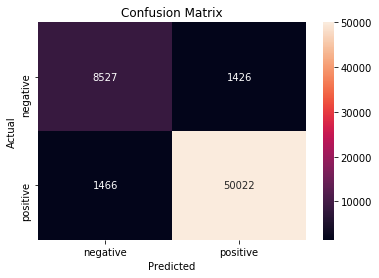


Confusion Matrix for Test data


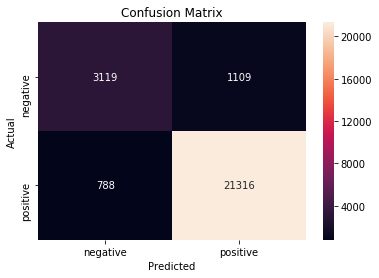

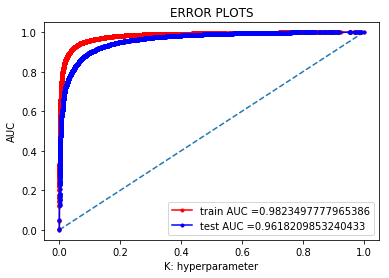


AUC (Train): 0.9823497777965386

AUC (Test): 0.9618209853240433

F1 SCORE (Train) : 0.9719048729307531

F1 SCORE (Test) : 0.9573985492600328

RECALL (Train): 0.9715273461777502

RECALL (Test): 0.9643503438291712

PRECISION  (Train) : 0.9722826932047893

PRECISION  (Test) : 0.950546265328874


In [38]:
optimal_alpha = tfidf_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L2 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L2.fit(X_train_tfidf,y_train)

# predict the response
test_pred = model_calib_L2.predict(x_test_tfidf)
train_pred = model_calib_L2.predict(X_train_tfidf)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L2,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

In [39]:
optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(X_train_tfidf, y_train)

show_most_informative_features(tf_idf_vect.get_feature_names(), optimal_model)

Important words in negative reviews

-4.646603655781997 not
-4.233447213348982 disappointed
-3.463384663808446 not good
-3.353331441552122 worst
-3.2563477896380255 not worth
-3.2371812267728304 disappointing
-3.0255028819207466 terrible
-2.9587028268208897 unfortunately
-2.9089081042682063 horrible
-2.809973544027651 disappointment
-----------------------------------------

Important words in positive reviews

6.267910237709861 great
4.686732783445354 best
4.517835844230264 delicious
4.296794112630621 good
3.9719583367670865 perfect
3.647112275490669 love
3.6218445456988073 loves
3.545871908753643 nice
3.4436128844949345 excellent
3.247869501741278 wonderful


### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(28000, 13) (12000, 13) (28000,) (12000,)

Confusion Matrix for Train data


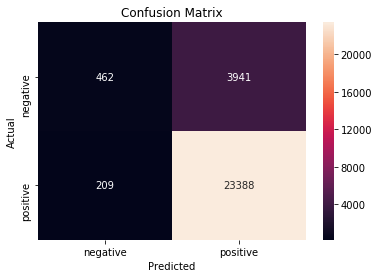


Confusion Matrix for Test data


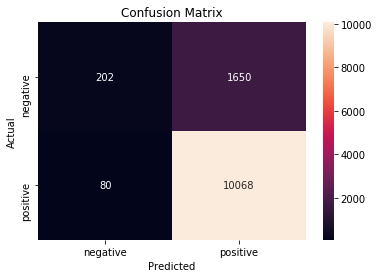

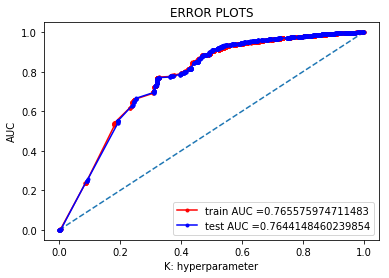


AUC (Train): 0.765575974711483

AUC (Test): 0.7644148460239854

F1 SCORE (Train) : 0.9185092094411498

F1 SCORE (Test) : 0.9208817341992133

RECALL (Train): 0.991142941899394

RECALL (Test): 0.9921166732361056

PRECISION  (Train) : 0.8557942112773976

PRECISION  (Test) : 0.8591909882232462


In [40]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:40000]
y = final['Score'][:40000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', TfidfVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', TfidfVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_alpha = tfidf_train.best_params_.get('alpha')

optimal_model =SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib.fit(train_features,y_train)

# predict the response
test_pred = model_calib.predict(test_features)
train_pred = model_calib.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.4] Word2Vec

In [41]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


In [42]:
# Train your own Word2Vec model using your own text corpus

# Train data
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# Test data
list_of_test_sentence = []
for sentance in x_test:
    list_of_test_sentence.append(sentance.split())

In [43]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # train data
    w2v_model_tr=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    # train model on test data
    w2v_model_test = Word2Vec(list_of_test_sentence,min_count=5,size=50, workers=4)
    print(w2v_model_tr.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_tr.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8266610503196716), ('awesome', 0.8200668096542358), ('fantastic', 0.8135119080543518), ('excellent', 0.7982574701309204), ('perfect', 0.7907010316848755), ('wonderful', 0.7888938784599304), ('terrific', 0.7881108522415161), ('amazing', 0.7353063225746155), ('nice', 0.6848068833351135), ('decent', 0.6833682060241699)]
[('greatest', 0.8013015985488892), ('best', 0.7241092324256897), ('tastiest', 0.6930979490280151), ('nastiest', 0.6824731826782227), ('disgusting', 0.6481608152389526), ('awful', 0.6412649154663086), ('horrible', 0.6180609464645386), ('experienced', 0.6013039350509644), ('closest', 0.5976827144622803), ('superior', 0.5890876650810242)]


In [44]:
# train data operation
w2v_train_words = list(w2v_model_tr.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[0:50])

number of words that occured minimum 5 times  14910
sample words  ['aroma', 'flavor', 'seem', 'fine', 'weak', 'value', 'used', 'entire', 'bottle', 'quart', 'home', 'made', 'ice', 'cream', 'people', 'guessing', 'not', 'enough', 'licorice', 'spent', 'twice', 'price', 'really', 'concentrated', 'would', 'great', 'never', 'waste', 'money', 'item', 'like', 'shampoo', 'know', 'necessarily', 'hair', 'definitely', 'cleans', 'scalp', 'well', 'also', 'thickest', 'lather', 'ever', 'hellman', 'arguably', 'absolute', 'finest', 'mass', 'market', 'mayonnaise']


In [45]:
# test data operation
w2v_test_words = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_test_words))
print("sample words ", w2v_test_words[0:50])

number of words that occured minimum 5 times  9806
sample words  ['used', 'use', 'cheaper', 'grocery', 'store', 'brands', 'two', 'cats', 'got', 'sick', 'no', 'idea', 'causing', 'changed', 'cat', 'food', 'anyway', 'love', 'healthy', 'made', 'good', 'cheese', 'corn', 'big', 'round', 'fresh', 'popcorn', 'evenly', 'seasoned', 'really', 'cheesy', 'flavor', 'not', 'salty', 'greasy', 'taste', 'sensational', 'ordering', 'disappointment', 'searching', 'awhile', 'find', 'flavored', 'water', 'artificial', 'sweetener', 'kind', 'saw', 'reviews', 'thought']


## [4.4.1] Converting text into vectors using Avg W2V

#### [4.4.1.1] Avg W2v

In [46]:
# average Word2Vec

# train data operation
exists = os.path.isfile(avg_w2v_trained_model_100000)
if exists:
    print("yes exist")
    final_w2v_train = load(avg_w2v_trained_model_100000)
else:
    print("not exist")
    # compute average word2vec for each review.
    final_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words:
                vec = w2v_model_tr.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_train.append(sent_vec)
    print(len(final_w2v_train))
    print(len(final_w2v_train[0]))
    dump(final_w2v_train,avg_w2v_trained_model_100000)


# test data operation
exists = os.path.isfile(avg_w2v_test_model_100000)
if exists:
    print("yes exist")
    final_w2v_test = load(avg_w2v_test_model_100000)
else:
    print("not exist")
    final_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words:
                vec = w2v_model_test.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_test.append(sent_vec)
    print(len(final_w2v_test))
    print(len(final_w2v_test[0]))
    dump(final_w2v_test,avg_w2v_test_model_100000)

yes exist
yes exist


### Hyper parameter tunig using GridSearch

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.7s
/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/pranay/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a mem

=======Training========
0.9046980072495765
{'alpha': 0.01}
SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


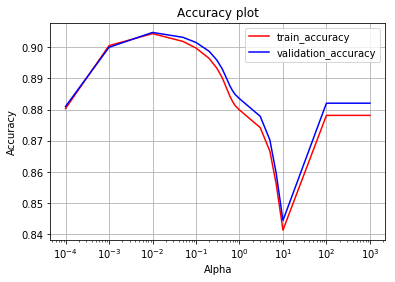

In [47]:
w2v_train = finding_best_alpha (final_w2v_train,y_train, 'gridsearch','SGDClassifier','l2')

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

plotAccuracyGraph(w2v_train)

# Linear SVM L1 Regularization


Optimal best alpha is : 0.01

Confusion Matrix for Train data


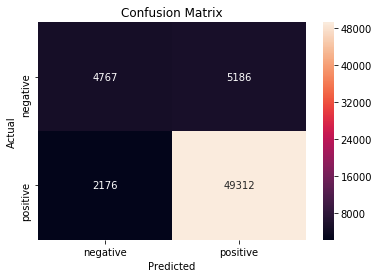


Confusion Matrix for Test data


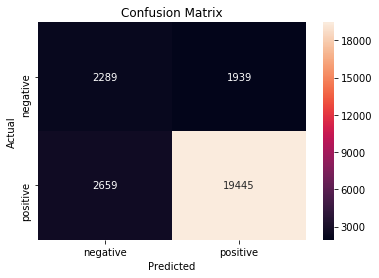

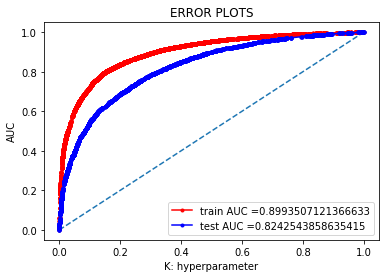


AUC (Train): 0.8993507121366633

AUC (Test): 0.8242543858635415

F1 SCORE (Train) : 0.9305379955843224

F1 SCORE (Test) : 0.8942696835908757

RECALL (Train): 0.9577377252952144

RECALL (Test): 0.8797050307636627

PRECISION  (Train) : 0.9048405446071416

PRECISION  (Test) : 0.9093247287691733


In [48]:
optimal_alpha = w2v_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L1 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L1.fit(final_w2v_train,y_train)

# predict the response
test_pred = model_calib_L1.predict(final_w2v_test)
train_pred = model_calib_L1.predict(final_w2v_train)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L1,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# Linear SVM L2 Regularization 


Optimal best alpha is : 0.01

Confusion Matrix for Train data


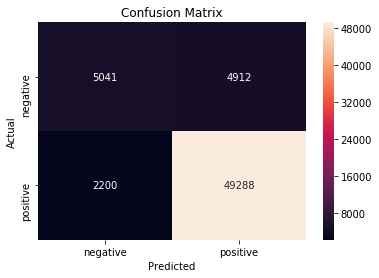


Confusion Matrix for Test data


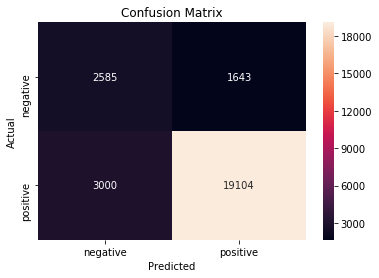

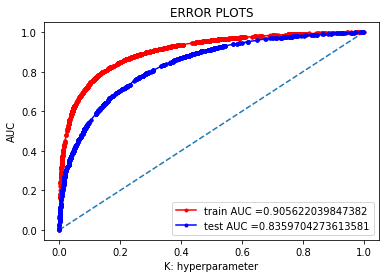


AUC (Train): 0.905622039847382

AUC (Test): 0.8359704273613581

F1 SCORE (Train) : 0.9327075921580501

F1 SCORE (Test) : 0.8916478028517422

RECALL (Train): 0.9572715972653822

RECALL (Test): 0.8642779587404995

PRECISION  (Train) : 0.9093726937269373

PRECISION  (Test) : 0.9208078276377307


In [49]:
optimal_alpha = w2v_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L2 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L2.fit(final_w2v_train,y_train)

# predict the response
test_pred = model_calib_L2.predict(final_w2v_test)
train_pred = model_calib_L2.predict(final_w2v_train)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L2,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.4.1.2] TFIDF weighted W2v

In [50]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


In [51]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TF-IDF weighted Word2Vec

# Train data operation

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_trained_model_100000)
exists = False
if exists:
    print("yes exist")
    final_tfidf_w2v_tr = load(w2v_tf_idf_trained_model_100000)
else:   
    print("not exist")
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    final_tfidf_w2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words and word in tfidf_feat:
                vec = w2v_model_tr.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_tr.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_tr,w2v_tf_idf_trained_model_100000)
    
    
# Test data operation ============

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_test_model_100000)
exists = False
if exists:
    print("yes exist")
    final_tfidf_w2v_test = load(w2v_tf_idf_test_model_100000) 

else:   
    print("not exist")
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    final_tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words and word in tfidf_feat:
                vec = w2v_model_test.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_test.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_test,w2v_tf_idf_test_model_100000)
        

  0%|          | 8/61441 [00:00<36:35, 27.99it/s]

not exist


  0%|          | 8/26332 [00:00<11:45, 37.34it/s]

not exist


100%|██████████| 26332/26332 [20:32<00:00, 22.96it/s]


### Hyper parameter tunig using GridSearch

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

=======Training========
0.878357148358366
{'alpha': 0.01}
SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=1, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


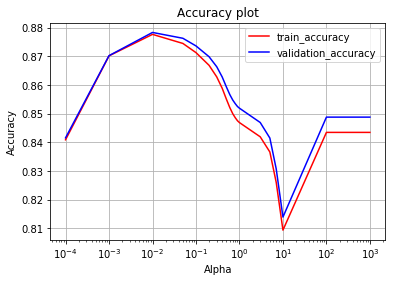

In [52]:
w2v_tfidf_train = finding_best_alpha (final_tfidf_w2v_tr,y_train, 'gridsearch','SGDClassifier','l2')

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

plotAccuracyGraph(w2v_tfidf_train) 

# Linear SVM L1 Regularization


Optimal best alpha is : 0.01

Confusion Matrix for Train data


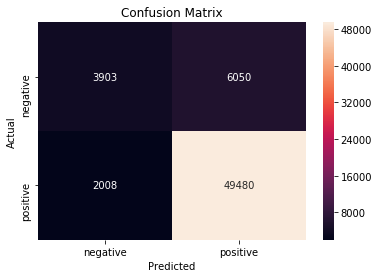


Confusion Matrix for Test data


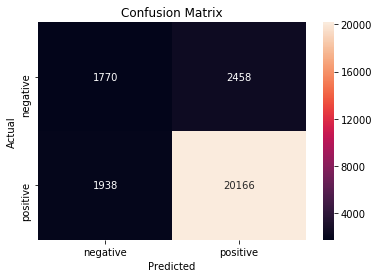

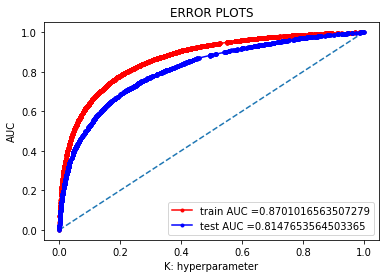


AUC (Train): 0.8701016563507279

AUC (Test): 0.8147653564503365

F1 SCORE (Train) : 0.9247042553589115

F1 SCORE (Test) : 0.9017170452512968

RECALL (Train): 0.9610006215040398

RECALL (Test): 0.9123235613463626

PRECISION  (Train) : 0.8910498829461553

PRECISION  (Test) : 0.8913543140028288


In [53]:
optimal_alpha = w2v_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L1 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L1.fit(final_tfidf_w2v_tr,y_train)

# predict the response
test_pred = model_calib_L1.predict(final_tfidf_w2v_test)
train_pred = model_calib_L1.predict(final_tfidf_w2v_tr)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L1,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# Linear SVM L2 Regularization


Optimal best alpha is : 0.01

Confusion Matrix for Train data


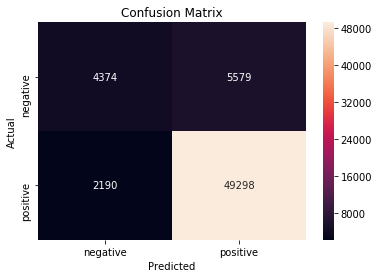


Confusion Matrix for Test data


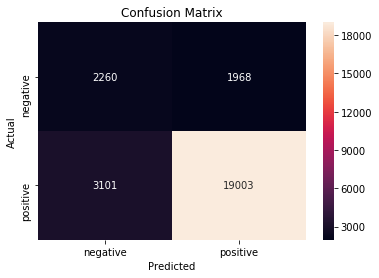

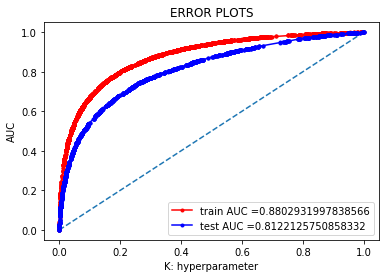


AUC (Train): 0.8802931997838566

AUC (Test): 0.8122125750858332

F1 SCORE (Train) : 0.9269590560804776

F1 SCORE (Test) : 0.8823215322112595

RECALL (Train): 0.9574658172778123

RECALL (Test): 0.8597086500180963

PRECISION  (Train) : 0.8983362793155603

PRECISION  (Test) : 0.906156120356683


In [54]:
optimal_alpha = w2v_train.best_params_.get('alpha')

print('\n'+color.RED+'Optimal best alpha is : '+color.END+color.BOLD+str(optimal_alpha)+color.END)

optimal_model = SGDClassifier(alpha=optimal_alpha,  average=False,
       class_weight='balanced', early_stopping=False, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=1, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

# https://www.kaggle.com/mpearmain/calibrated-sgdclassifier

model_calib_L2 = CalibratedClassifierCV(base_estimator=optimal_model, cv=5, method='isotonic')

# fitting the model
model_calib_L2.fit(final_tfidf_w2v_tr,y_train)

# predict the response
test_pred = model_calib_L2.predict(final_tfidf_w2v_test)
train_pred = model_calib_L2.predict(final_tfidf_w2v_tr)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(model_calib_L2,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# [6] Conclusions

In [58]:
import pandas as pd
from prettytable import PrettyTable

print(color.BOLD+'\t\t\t\t Linear SVM  '+color.END)
print('\n')

print(color.BOLD+'For BOW and TFIDF, We have considered 100k points'+color.END)
print(color.BOLD+'For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points'+color.END)


x = PrettyTable()
x.field_names =  ['Metric','BOW L1','BOW L2','BOW-Extra-Feature','TFIDF L1', 'TFIDF L2', 'TFIDF-Extra-Feature']

x.add_row(["Alpha Value ", 0.001,0.001,0.001,0.0001,0.0001,0.0001])

x.add_row(["AUC Train ", 0.93048,0.98541,0.95718,0.95727, 0.9823,0.76557])
x.add_row(["AUC Test ", 0.92056,0.95526,0.93812,0.94694,0.9618,0.764418])

x.add_row(["F1 SCORE Train ", 0.94162,0.97515,0.95743,0.9560,0.9719,0.91850])
x.add_row(["F1 SCORE Test ", 0.94083,0.9555,0.95184,0.9515,0.9573,0.92088])

x.add_row(["RECALL Train ",0.98042,0.97572,0.97813,0.96960,0.97152,0.91850])
x.add_row(["RECALL Test ", 0.9780,0.96353,0.97299,0.96557,0.96435,0.9911])

x.add_row(["PRECISION Train ", 0.90577,0.9745,0.9376,0.94279,0.97228,0.8557])
x.add_row(["PRECISION Test ",0.90633,0.9477,0.93159,0.9379,0.9505,0.8591])


print('\n')
print(x)


x1 = PrettyTable()
x1.field_names =  ['Metric','W2V L1','W2V L2','W2V TFIDF L1', 'W2V TFIDF L2']

x1.add_row(["Alpha Value ", 0.01,0.25,0.01,0.01])

x1.add_row(["AUC Train ", 0.89935,0.905622,0.87010,0.8802])
x1.add_row(["AUC Test ", 0.82425,0.8359,0.8147,0.81221])

x1.add_row(["F1 SCORE Train ", 0.9305,0.9327,0.9247,0.9269])
x1.add_row(["F1 SCORE Test ", 0.8942,0.89164,0.90131,0.88232])

x1.add_row(["RECALL Train ",0.9577,0.95727,0.96100,0.95746])
x1.add_row(["RECALL Test ", 0.8797,0.8642,0.9123,0.8597])

x1.add_row(["PRECISION Train ", 0.90484,0.9093,0.89104,0.8983])
x1.add_row(["PRECISION Test ",0.9093,0.9208,0.8913,0.90615])

print('\n')
print(x1)

				 Linear SVM  


For BOW and TFIDF, We have considered 100k points
For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 50k points


+------------------+---------+---------+-------------------+----------+----------+---------------------+
|      Metric      |  BOW L1 |  BOW L2 | BOW-Extra-Feature | TFIDF L1 | TFIDF L2 | TFIDF-Extra-Feature |
+------------------+---------+---------+-------------------+----------+----------+---------------------+
|   Alpha Value    |  0.001  |  0.001  |       0.001       |  0.0001  |  0.0001  |        0.0001       |
|    AUC Train     | 0.93048 | 0.98541 |      0.95718      | 0.95727  |  0.9823  |       0.76557       |
|    AUC Test      | 0.92056 | 0.95526 |      0.93812      | 0.94694  |  0.9618  |       0.764418      |
| F1 SCORE Train   | 0.94162 | 0.97515 |      0.95743      |  0.956   |  0.9719  |        0.9185       |
|  F1 SCORE Test   | 0.94083 |  0.9555 |      0.95184      |  0.9515  |  0.9573  |       0.92088       |